In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
%matplotlib inline

import pandas as pd

# Import data & initial guess

In [2]:
def create_filepaths(numbers, pre_path):
    padded_numbers = []
    file_ext = '.dat'
    for n in numbers:
        if n <= 9:
            padded_numbers = np.append(padded_numbers, pre_path + '00' + str(n) + file_ext)
        elif n <= 99:
            padded_numbers = np.append(padded_numbers, pre_path + '0' + str(n) + file_ext)
        else:
            padded_numbers = np.append(padded_numbers, pre_path + str(n) + file_ext)
    return padded_numbers

In [3]:
def decayingSinModel(time, freq, T_decay, amp, phase, offset):
    # Linearly decaying sinusoidal function
    return amp * np.exp(-time/T_decay) * np.sin(2*np.pi*( freq*time ) + np.radians(phase)) + offset

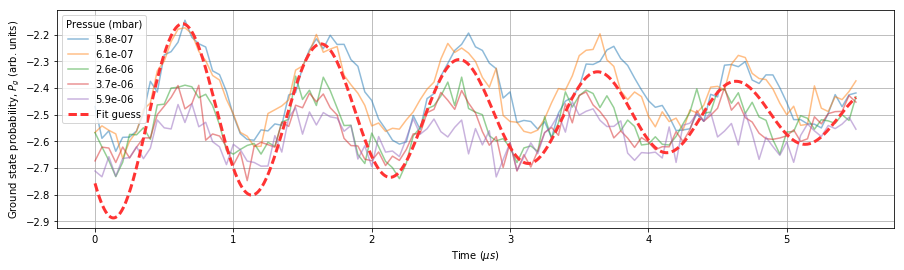

In [4]:
date = '270317'
file_path = "C:\data\\" + date + "\\SR" + date + "_"
file_numbers = [26,31,29,28,27]
pressures = [5.8E-7, 6.1E-7, 2.6E-6, 3.7E-6, 5.9E-6 ]
full_paths = create_filepaths(file_numbers, file_path)

matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
i = 0
for path in full_paths:
    data = np.loadtxt(path)
    time = data[:,1] * 10E6
    p_g = data[:,4] * 10E9
    plt.plot(time, p_g, alpha=0.5, label=str(pressures[i]))
    i += 1
    
freq_guess = 1 # MHz
T_decay_guess = 4 # us
amp_guess = 0.4
phase_guess = 220
offset_guess = -2.5
guess = [freq_guess, T_decay_guess, amp_guess, phase_guess, offset_guess]
timeSteps = np.linspace(np.min(time), np.max(time), 1000)

plt.plot(timeSteps, decayingSinModel(timeSteps, *guess), '--', lw=3, color=[1.0,0.2,0.2], label='Fit guess')
plt.xlabel('Time ($\mu s$)')
plt.ylabel('Ground state probability, $P_g$ (arb. units)')
plt.grid()
plt.legend(title='Pressue (mbar)')


# Fit sinusoidal waveforms

,Pressure,Frequency,Frequency error,T decay,T decay error,Amplitude,Amplitude error,Phase,Phase error,Offset,Offset error,Phase shift
0,5.800000e-07,0.989458,0.002527,7.972519,0.998300,0.227277,0.009233,208.117412,2.419301,-2.407383,0.002864,0.000000
1,6.100000e-07,1.003216,0.003216,6.483186,0.841831,0.224576,0.010987,214.531753,2.950429,-2.410123,0.003318,31.178869
2,2.600000e-06,1.025575,0.005335,7.373946,1.747826,0.157589,0.012940,214.967336,4.983287,-2.525935,0.004006,71.860631
3,3.700000e-06,1.026242,0.004885,10.787640,3.369401,0.132336,0.010548,222.548097,4.882747,-2.551630,0.003454,80.642015
4,5.900000e-06,1.043216,0.008099,7.343446,2.577733,0.106534,0.013104,214.694836,7.495834,-2.583633,0.004067,103.341826


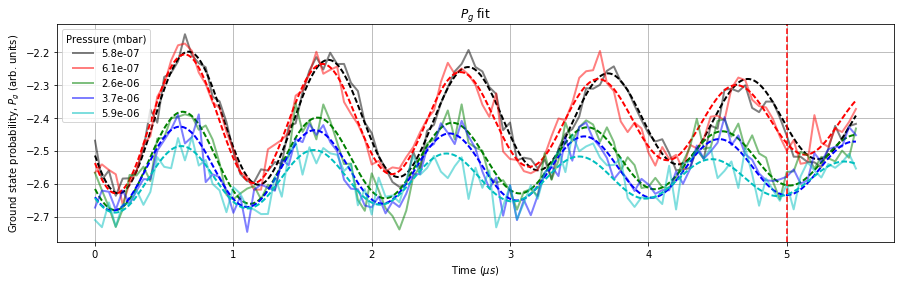

In [5]:
matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
colors = ['k','r','g','b','c','m','y']
params = ['Frequency', 'T decay', 'Amplitude', 'Phase', 'Offset']

popts = []
perrs = []
df = pd.DataFrame(columns=['Pressure', *params, *[p + ' error' for p in params]])
for i, path in enumerate(full_paths):
    data = np.loadtxt(path)
    time = data[:,1] * 10E6
    p_g = data[:,4] * 10E9
    
    popt,pcov = curve_fit(decayingSinModel, time, p_g, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    popts = np.concatenate((popts, popt), axis=0)
    perrs = np.concatenate((perrs, perr), axis=0)

    df.loc[i] = [pressures[i], *popt, *perr]
    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)

    p_g_fit = decayingSinModel(timeSteps, *popt)
    plt.plot(time, p_g, '-', lw=2, color=colors[np.mod(i, len(colors))], alpha=0.5, label=str(pressures[i]))
    plt.plot(timeSteps, p_g_fit, '--', lw=2, color=colors[np.mod(i, len(colors))], alpha=1.0)

plt.xlabel('Time ($\mu s$)')
plt.ylabel('Ground state probability, $P_g$ (arb. units)')
plt.title('$P_g$ fit')
plt.grid()
plt.legend(title='Pressure (mbar)')

popts = np.reshape(popts, [len(file_numbers), len(params)])
perrs = np.reshape(perrs, [len(file_numbers), len(params)])
evalutation_time = 5.0 # us
ref_popt = popts[0]
diff_freq = popts[:,0] - ref_popt[0]
diff_init_phase = popts[:,3] - ref_popt[3]
diff_eval_phase = (360 * diff_freq * evalutation_time) + diff_init_phase # MHz * us

plt.axvline(x=evalutation_time, color='r', linestyle='--')

df['Phase shift'] = diff_eval_phase
columns = ['Pressure', *list(np.array([[p, p + ' error'] for p in params]).flatten()), 'Phase shift']
df[columns]

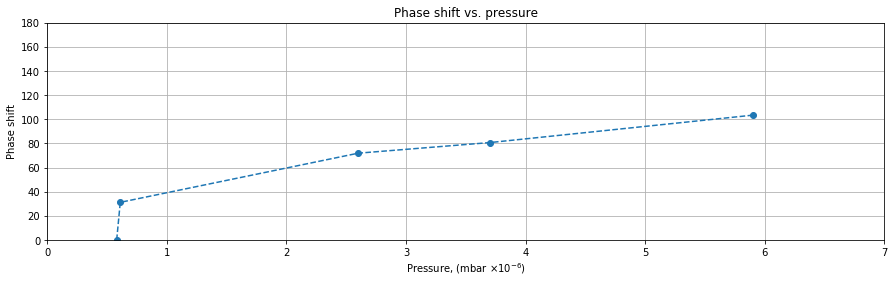

In [6]:
plt.plot(df['Pressure']*1E6, df['Phase shift'], 'o--')
plt.title('Phase shift vs. pressure')
plt.xlabel('Pressure, (mbar $\\times 10^{-6}$)')
plt.ylabel('Phase shift')
plt.xlim([0,7])
plt.ylim([0,180])
plt.grid()